In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Выделение краев алгоритмом Canny:

In [15]:
def detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 150)
    return edges

# 2.пороговым методом с глобальным порогом T, реализовать определение порога:

## 2.1 Определение порога на основе площади (P-tile)

In [16]:
def ptile_threshold(image, p):
    flat_image = image.flatten()
    flat_image.sort()
    idx = int(len(flat_image) * p)
    threshold = flat_image[idx]
    return threshold

## 2.2 Пороговый метод с последовательными приближениями

In [31]:
def iterative_threshold(image, initial_threshold=128, max_iterations=100, tolerance=1):
    old_threshold = initial_threshold
    new_threshold = 0
    for _ in range(max_iterations):
        below_threshold = image < old_threshold
        above_threshold = image >= old_threshold
        mean_below = np.mean(image[below_threshold])
        mean_above = np.mean(image[above_threshold])
        new_threshold = (mean_below + mean_above) / 2
        if abs(new_threshold - old_threshold) < tolerance:
            break
        old_threshold = new_threshold
    return new_threshold


## 2.3 Метод k-средних

In [18]:
def kmeans_threshold(image, k):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(image.flatten().astype(np.float32), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    threshold = int(centers[-1][0])
    return threshold

2.4 (для 2.2 и 2.3) добавить гистограмму изображения для поиска на
ней пиков и последующего их сглаживания (реализовать в программе
сравнение при нескольких различных количествах сглаживаний).

In [19]:
def calculate_histogram(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.flatten()
    return hist

def smooth_histogram(hist, smoothing_factor=1):
    from scipy.ndimage.filters import gaussian_filter
    return gaussian_filter(hist, sigma=smoothing_factor)

In [38]:
def iterative_threshold_with_hist(image, initial_threshold=128, max_iterations=100, tolerance=1, smoothing_factors: list =None):
    if smoothing_factors is None:
        smoothing_factors = [1, ]

    plt.figure(figsize=(10, len(smoothing_factors) * 3))

    for i, smoothing_factor in enumerate(smoothing_factors):
        hist = calculate_histogram(image)
        smoothed_hist = smooth_histogram(hist, smoothing_factor)
        
        new_threshold = iterative_threshold(image, initial_threshold, max_iterations, tolerance)
        
        ax = plt.subplot(len(smoothing_factors), 1, i + 1)
        ax.set_title("Histogram After Smoothing (factor={})".format(smoothing_factor))
        ax.plot(smoothed_hist, color='blue')
        ax.axvline(x=new_threshold, color='red', label='Threshold: {:.2f}'.format(new_threshold))
        ax.legend()

    plt.tight_layout()
    plt.show()

In [21]:
def kmeans_threshold_with_hist(image, k, smoothing_factor=1):
    hist = calculate_histogram(image)
    smoothed_hist = smooth_histogram(hist, smoothing_factor)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(smoothed_hist.reshape(-1, 1).astype(np.float32), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    threshold = int(centers[-1][0])

    plt.figure()
    plt.title("Histogram After Smoothing (factor={})".format(smoothing_factor))
    plt.plot(smoothed_hist, color='blue')
    plt.axvline(x=threshold, color='red', label='Threshold')
    plt.legend()
    plt.show()

    return threshold

# 3. Пороговый метод с адаптивным порогом

In [22]:
def adaptive_threshold(image, block_size, C):
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)

# 4. Обработка видео

In [23]:
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        edges = adaptive_threshold(frame)
        cv2.imshow('Edges', edges)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# video_path = '../assets/sample_640x360.mp4'
# process_video(video_path)

# Демонстрация работы

In [24]:
image_path = '../assets/cars.jpg'
image_color = cv2.imread(image_path)
image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

C:\Users\Андрей\AppData\Local\Temp\ipykernel_22668\1717709331.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


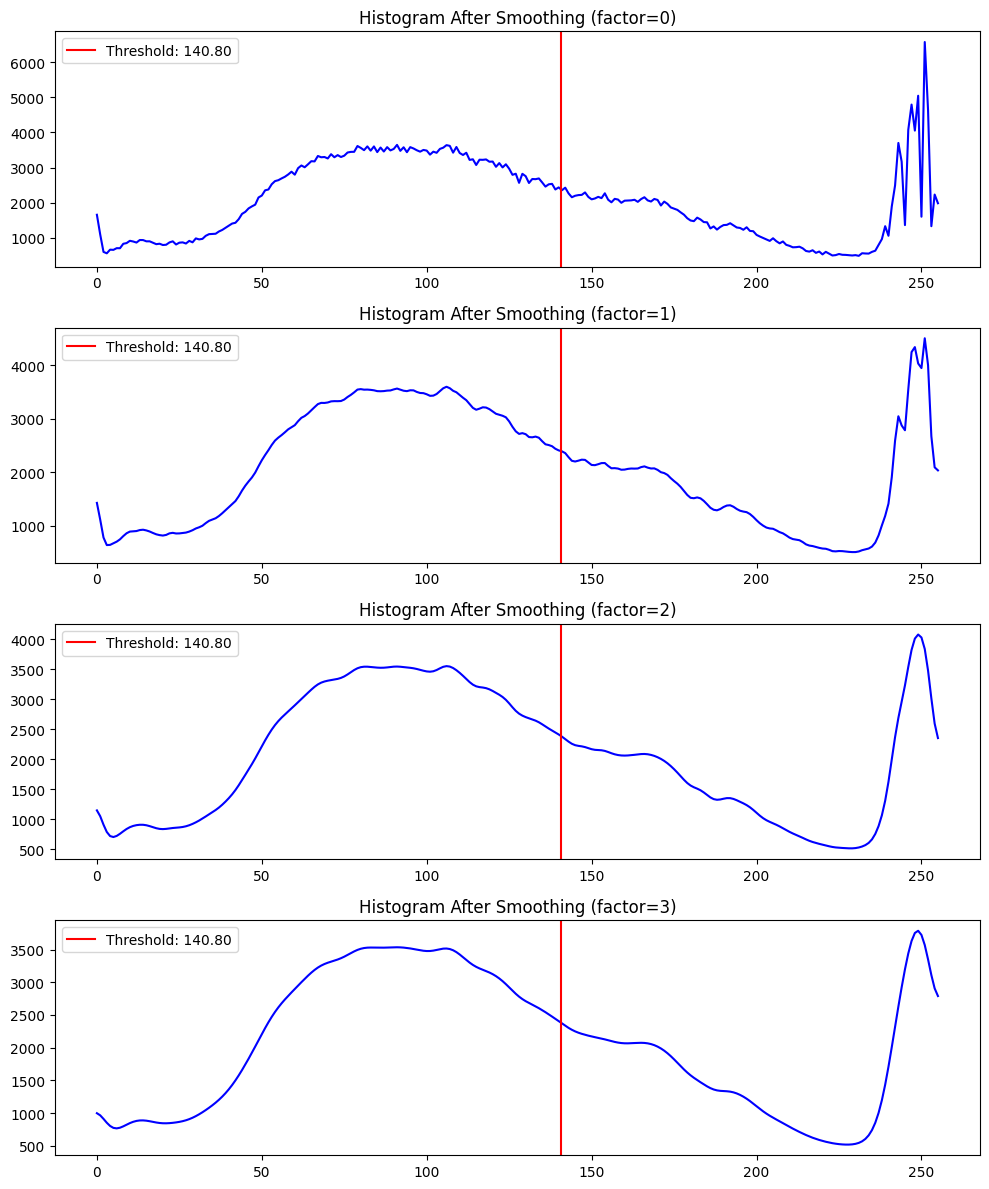

In [39]:
iterative_threshold_with_hist(image,250, smoothing_factors=[0, 1, 2, 3])

68
68.52218495506817 20
94.10391771711647 68.52218495506817
111.28801851006365 94.10391771711647
122.5715135721407 111.28801851006365
129.64161630820647 122.5715135721407
133.9040656181279 129.64161630820647
136.24735568117092 133.9040656181279
137.98435944381708 136.24735568117092
138.55901033142868 137.98435944381708
138.55901033142868
195


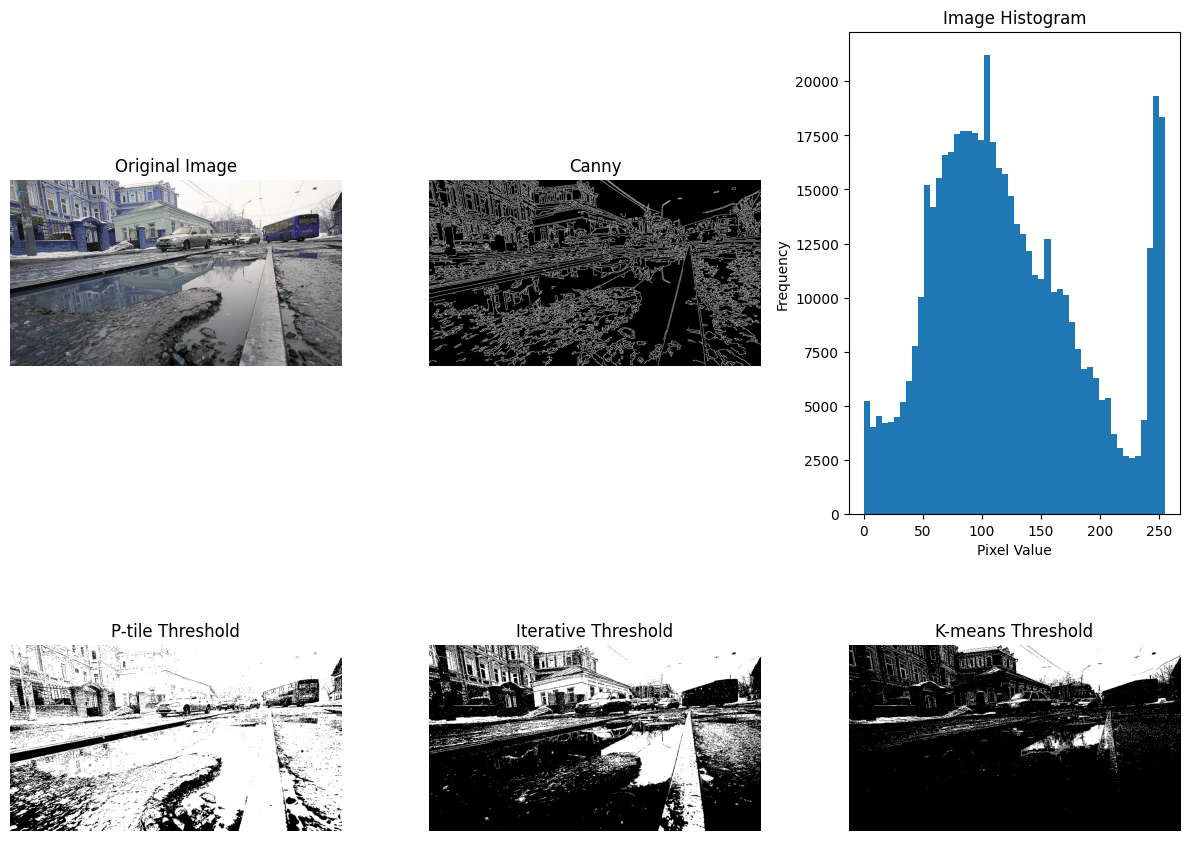

In [26]:
edges = detect_edges(image_color)

p = 0.2
ptile_thresh = ptile_threshold(image, p)
print(ptile_thresh)

iter_thresh = iterative_threshold(image, initial_threshold=20, max_iterations=1000)
print(iter_thresh)

k = 2
kmeans_thresh = kmeans_threshold(image, k)
print(kmeans_thresh)

block_size = 11
C = 2


plt.figure(figsize=(12, 10))

plt.subplot(2, 3, 1)
plt.imshow(image_color)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.hist(image.flatten(), bins=50)
plt.title('Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
plt.imshow(image > ptile_thresh, cmap='gray')
plt.title('P-tile Threshold')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(image > iter_thresh, cmap='gray')
plt.title('Iterative Threshold')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(image > kmeans_thresh, cmap='gray')
plt.title('K-means Threshold')
plt.axis('off')

plt.tight_layout()
plt.show()
